## Amazon Business Research Analyst Hiring Challenge

This project was done as a part of Amazon Business Research Analyst Hiring Challenge. Here I was provided an dataset for the candidates for a XyZ company. I had to make prediction about the FitmentPercent. Also, the prediction had to be free from any bias. On the predicted Fitmentpercent, I had to predict if there was any bias and if there is bias then what kind of bias was present. 

By solving this project, I was qualified for the round 2. 

In [ ]:
#Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp,fmin, tpe, Trials
from hyperopt.pyll.base import scope
from xgboost import XGBRegressor,XGBClassifier
from functools import partial
from sklearn import model_selection
from sklearn.metrics import r2_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataset

train_all = pd.read_csv('Train.csv')
test_all = pd.read_csv('Test.csv')

In [3]:
train_all.head()

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,...,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,11041,John,English,35,Male,JR85289,B.Tech,Electrical,Tier 1,7,...,21,26,Married,5,SSE,Enterprise,Design,20,YearsOfExperince,95.40
1,15079,William,English,26,Male,JR87525,B.Tech,Artificial Intelligence,Tier 3,7,...,15,19,Married,5,BA,MidSized,Engineering,6,NaN,67.09
2,18638,James,English,36,Female,JR87525,PhD,Computer Science,Tier 1,6,...,15,24,Single,5,SDE,MidSized,Engineering,19,Gender,91.26
3,3941,Charles,English,29,Female,JR87525,BCA,Information Technology,Tier 2,5,...,16,24,Married,5,SDE,Startup,Product,16,Gender,72.29
4,5936,George,English,25,Male,JR70175,Dual M.Tech,Computer Science,Tier 3,8,...,24,32,Married,5,SDE,Enterprise,Engineering,10,DegreeBranch,86.34


In [4]:
test_all.head()

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,5664,Theo,Native,35,Male,JR85289,PhD,Information Technology,Tier 2,5,5,2016,27,34,Single,4,SDE,Enterprise,Finance,18
1,23568,Vernie,English,35,Male,JR85289,B.Tech,Information Technology,Tier 3,9,12,2009,29,33,Married,4,EM,Enterprise,Engineering,8
2,21490,Wendell,English,28,Male,JR87525,M.Tech,Artificial Intelligence,Tier 2,9,2,2019,18,25,Married,3,SDE,Startup,Engineering,18
3,8363,West,Hindi,37,Male,JR87525,MS,Computer Science,Tier 2,8,11,2010,7,12,Single,5,DS,Enterprise,Product,17
4,6165,Alford,Hindi,36,Female,JR85289,PhD,Artificial Intelligence,Tier 2,7,6,2015,22,32,Married,4,SDE,Startup,Engineering,9


In [5]:
#To Approach this Problem, First I will make a regression model excluding the BiasInfluentialFactor from the dataset 
#to predict FitmentPercent.
# Once, I will have the FitmentPercent, I will make an classification model to predict BiasInfluentialFactor

In [6]:
#Checking for the Null values in train dataset:

train_all.isnull().sum()

EmpID                         0
EmpName                       0
LanguageOfCommunication       0
Age                           0
Gender                        0
JobProfileIDApplyingFor       0
HighestDegree                 0
DegreeBranch                  0
GraduatingInstitute           0
LatestDegreeCGPA              0
YearsOfExperince              0
GraduationYear                0
CurrentCTC                    0
ExpectedCTC                   0
MartialStatus                 0
EmpScore                      0
CurrentDesignation            0
CurrentCompanyType            0
DepartmentInCompany           0
TotalLeavesTaken              0
BiasInfluentialFactor      3336
FitmentPercent                0
dtype: int64

In [7]:
#Checking for the Null values in test dataset:
test_all.isnull().sum()

EmpID                      0
EmpName                    0
LanguageOfCommunication    0
Age                        0
Gender                     0
JobProfileIDApplyingFor    0
HighestDegree              0
DegreeBranch               0
GraduatingInstitute        0
LatestDegreeCGPA           0
YearsOfExperince           0
GraduationYear             0
CurrentCTC                 0
ExpectedCTC                0
MartialStatus              0
EmpScore                   0
CurrentDesignation         0
CurrentCompanyType         0
DepartmentInCompany        0
TotalLeavesTaken           0
dtype: int64

In [8]:
train_all.BiasInfluentialFactor.value_counts()
# train_all[train_all.BiasInfluentialFactor == 'Gender'].groupby('Gender')['Gender'].count()

DegreeBranch          2858
Gender                2605
YearsOfExperince      1561
CurrentCompanyType    1174
EmpScore               659
HighestDegree          582
Ethinicity             328
MartialStatus          280
LatestDegreeCGPA       262
Name: BiasInfluentialFactor, dtype: int64

In [9]:
#Replacing the null values in BiasInfluentialFactor as 'NoBias'
train_all.BiasInfluentialFactor.fillna('NoBias', inplace=True)

In [10]:
#Having a better look at categoriacl Values
cat_var = [var for var in train_all.columns if train_all[var].dtype == 'O']
cat_var

['EmpName',
 'LanguageOfCommunication',
 'Gender',
 'JobProfileIDApplyingFor',
 'HighestDegree',
 'DegreeBranch',
 'GraduatingInstitute',
 'MartialStatus',
 'CurrentDesignation',
 'CurrentCompanyType',
 'DepartmentInCompany',
 'BiasInfluentialFactor']

In [11]:
#Analysing the cardinality of these fileds

for var in cat_var:
    print(var ,':', train_all[var].nunique())

EmpName : 1766
LanguageOfCommunication : 3
Gender : 3
JobProfileIDApplyingFor : 9
HighestDegree : 8
DegreeBranch : 6
GraduatingInstitute : 3
MartialStatus : 2
CurrentDesignation : 8
CurrentCompanyType : 3
DepartmentInCompany : 5
BiasInfluentialFactor : 10


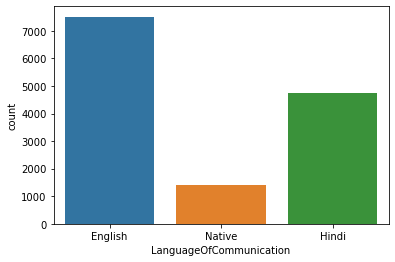

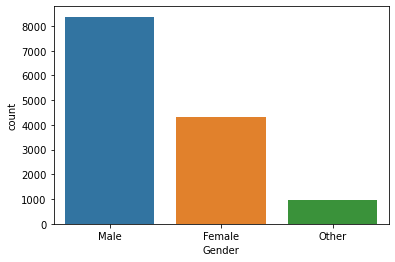

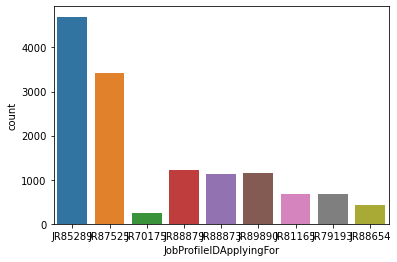

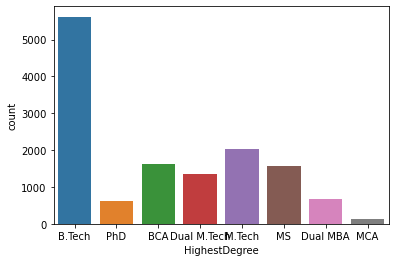

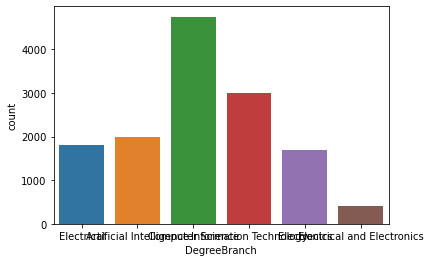

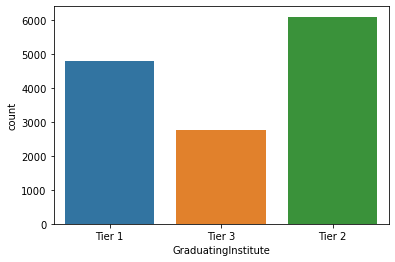

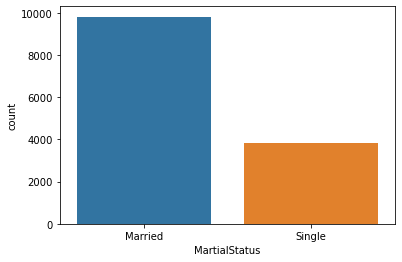

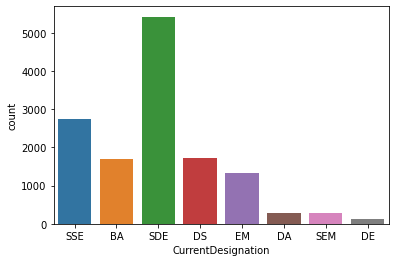

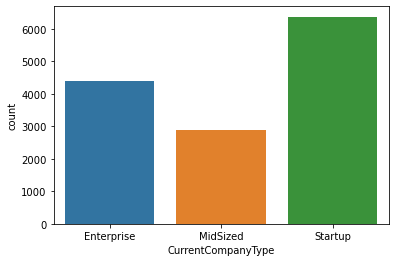

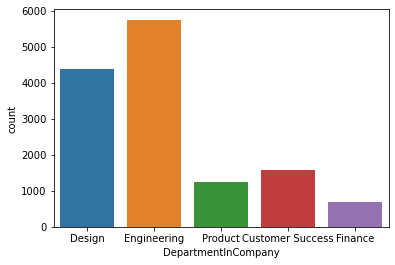

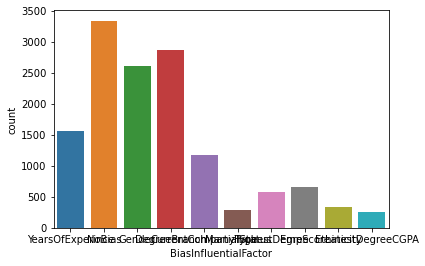

In [12]:
#EnpName contains hi cardinality and it will not help in prediction. We will drop this column while model building

#Lets plot the remaining data:

for var in cat_var:
    if var != 'EmpName':
        sns.countplot(x=var, data=train_all)
        plt.show()

In [13]:
#As this model will try to remove all biasness, I will make dummy of all the categorical values

In [14]:
#Analysing numerical features

In [15]:
#selecting all numerical features
 
num_var = [var for var in train_all.columns if train_all[var].dtype != 'O']
num_var

['EmpID',
 'Age',
 'LatestDegreeCGPA',
 'YearsOfExperince',
 'GraduationYear',
 'CurrentCTC',
 'ExpectedCTC',
 'EmpScore',
 'TotalLeavesTaken',
 'FitmentPercent']

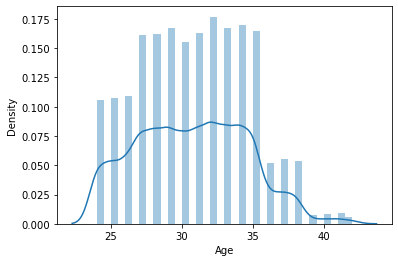

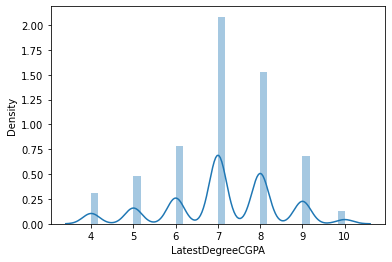

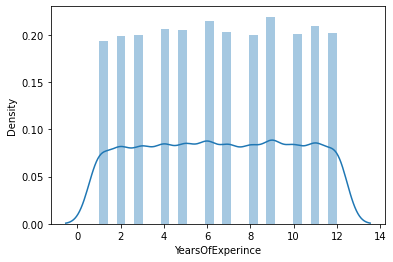

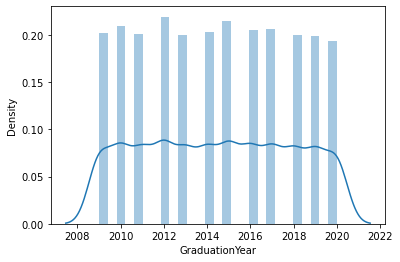

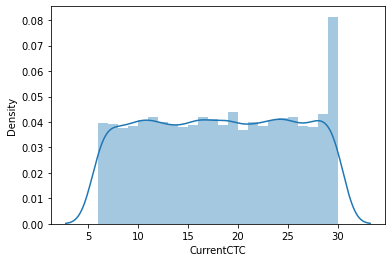

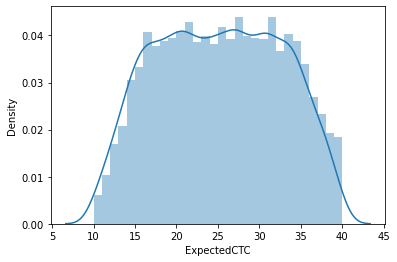

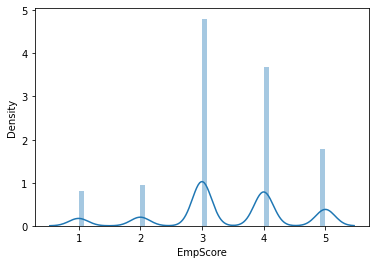

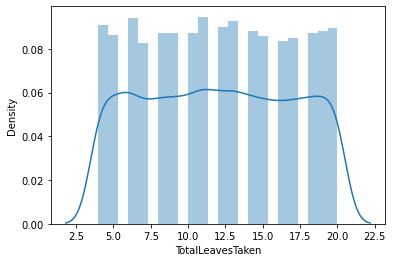

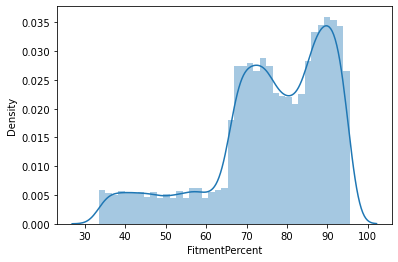

In [16]:
#EmpId should be deleted leter. Lets analyse the distribution of other numerical features

for var in num_var:
    if var != 'EmpID':
        sns.distplot(train_all[var])
        plt.show()

In [17]:
#Now, lets drop the unnecessary columns for the Regression model:
train = train_all.drop(['EmpName','EmpID','BiasInfluentialFactor'],axis=1)
test = test_all.drop(['EmpName','EmpID'],axis=1)

In [18]:
#Creating dummies for categoriacl features:

for var in cat_var:
    if var not in ('EmpName','BiasInfluentialFactor'):
        train = pd.get_dummies(train, columns=[var])
        test = pd.get_dummies(test, columns=[var])

In [19]:
#Deviding data into dependent and independent set for predicting FitmentPercent
X = train.drop('FitmentPercent', axis=1).values
y = train.FitmentPercent.values

In [20]:
## Optimizing the parameters for regression

# def optimize(params, x,y):
#     model = XGBRegressor(**params)
#     kf = model_selection.KFold(n_splits=5)
#     accuracies = []
#     for idx in kf.split(X=x,y=y):
#         train_idx,test_idx = idx[0],idx[1]
#         xtrain = x[train_idx]
#         ytrain = y[train_idx]
        
#         xtest = x[test_idx]
#         ytest = y[test_idx]
        
#         model.fit(xtrain,ytrain)
#         preds =  model.predict(xtest)

#         fold_acc = r2_score(ytest,preds)
#         accuracies.append(fold_acc)
#     return -1.0 * np.mean(accuracies)

# param_space = {
#     "max_depth" : scope.int(hp.quniform("max_depth",3,20, 1)) ,
#     "min_child_weight" : scope.int(hp.quniform("min_child_weight",1,8, 1)),
#     "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
#     'learning_rate': hp.uniform("learning_rate",0.01,1),
#     'reg_lambda': hp.uniform("reg_lambda",0.01,1),
#     'gamma': hp.uniform("gamma",0.01,1),
#     'subsample': hp.uniform("subsample",0.01,1)
#     }
    
# optimization_fuction = partial(optimize,x = X, y = y) 
# trials = Trials()
# result = fmin(
#     fn = optimization_fuction,
#     space = param_space,
#     algo = tpe.suggest,
#     max_evals = 10,
#     trials = trials
# )
# print(result)

In [21]:
#Making the Final Regression model
Xgb_regressor = XGBRegressor(gamma= 0.38627762228198526, 
                             learning_rate = 0.5139326736726783,
                             max_depth = 16,
                             min_child_weight = 7, 
                             n_estimators = 660,
                             reg_lambda = 0.38706814732560496,
                             subsample = 0.8484794387143008)

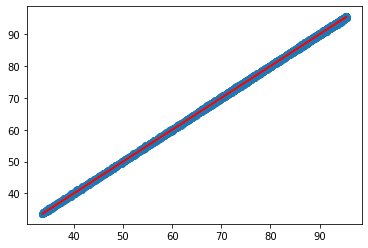

In [22]:
#Getting the test prediction
Xgb_regressor.fit(X,y)
Reg_pred = Xgb_regressor.predict(X)

#Ploting the prediction on train set
plt.plot(y,y,color='red')
plt.scatter(y,Reg_pred)

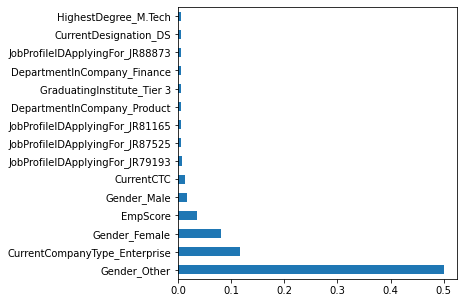

In [23]:
#Printing the 15 most important features for XGBModel

imp_feat=pd.Series(Xgb_regressor.feature_importances_,index=train.drop('FitmentPercent', axis=1).columns)
plt.figure(figsize=(5,5))
imp_feat.sort_values(ascending = False)[:15].plot(kind='barh')
plt.show()



In [24]:
imp_feat=pd.Series(Xgb_regressor.feature_importances_,index=train.drop('FitmentPercent', axis=1).columns)

imp_feat.sort_values(ascending = False)[:10].index

Index(['Gender_Other', 'CurrentCompanyType_Enterprise', 'Gender_Female',
       'EmpScore', 'Gender_Male', 'CurrentCTC',
       'JobProfileIDApplyingFor_JR79193', 'JobProfileIDApplyingFor_JR87525',
       'JobProfileIDApplyingFor_JR81165', 'DepartmentInCompany_Product'],
      dtype='object')

In [25]:
#Now, for getting values of BiasInfluentialFactor, we have to get the prediction of regression model added in the test set

test['FitmentPercent'] = Xgb_regressor.predict(test.values)

In [26]:
#Making dependent and independent for classification

Xc = train.values
yc = train_all.BiasInfluentialFactor.values

In [27]:
# # Optimztion function for Classification

# def optimize(params, x,y):
#     model = XGBClassifier(**params)
#     kf = model_selection.StratifiedKFold(n_splits=5)
#     accuracies = []
#     for idx in kf.split(X=x,y=y):
#         train_idx,test_idx = idx[0],idx[1]
#         xtrain = x[train_idx]
#         ytrain = y[train_idx]
        
#         xtest = x[test_idx]
#         ytest = y[test_idx]
        
#         model.fit(xtrain,ytrain)
#         preds =  model.predict(xtest)
#         fold_acc = f1_score(ytest,preds,average='weighted')
#         accuracies.append(fold_acc)
#     return -1.0 * np.mean(accuracies)

# param_space = {
#     "max_depth" : scope.int(hp.quniform("max_depth",3,20, 1)) ,
#     "min_child_weight" : scope.int(hp.quniform("min_child_weight",1,8, 1)),
#     "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
#     'learning_rate': hp.uniform("learning_rate",0.01,1),
#     'reg_lambda': hp.uniform("reg_lambda",0.01,1),
#     'gamma': hp.uniform("gamma",0.01,1),
#     'subsample': hp.uniform("subsample",0.01,1)
#     }

# optimization_fuction = partial(optimize,x = Xc, y = yc) 
# trials = Trials()
# result = fmin(
#     fn = optimization_fuction,
#     space = param_space,
#     algo = tpe.suggest,
#     max_evals = 15,
#     trials = trials
# )
# print(result)

In [28]:
#Making the Final classification model
Xgb_classifier = XGBClassifier(gamma= 0.38627762228198526, 
                             learning_rate = 0.40584054744039305,
                             max_depth = 10,
                             min_child_weight = 3, 
                             n_estimators = 1324,
                             reg_lambda = 0.034371066082082735,
                             subsample = 0.9583898062149305)
Xgb_classifier.fit(Xc,yc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.38627762228198526,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.40584054744039305, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1324, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.034371066082082735, scale_pos_weight=None,
              subsample=0.9583898062149305, tree_method='exact',
              validate_parameters=1, verbosity=None)

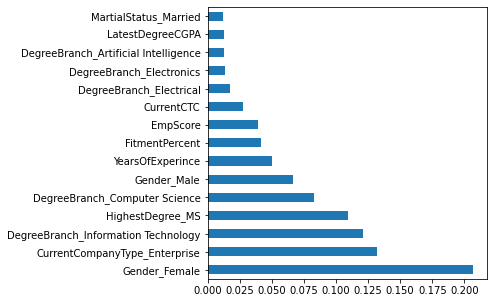

In [29]:
#Printing the 15 most important features for XGBModel

imp_feat=pd.Series(Xgb_classifier.feature_importances_,index=train.columns)
plt.figure(figsize=(5,5))
imp_feat.sort_values(ascending = False)[:15].plot(kind='barh')
plt.show()

In [30]:
#copying values of FitmentPercent in the train_all dataset

test_all['FitmentPercent'] = test['FitmentPercent']

In [31]:
#Getting predictions on test set for BiasInfluentialFactor
test_all['BiasInfluentialFactor'] = Xgb_classifier.predict(test.values)

In [32]:
#initially I replaced the null values with value NoBias, I am replaching that with null again in final prediction.

test_all['BiasInfluentialFactor'] = test_all['BiasInfluentialFactor'].apply(lambda x : np.nan if x =='NoBias' else x)

In [33]:
#Taking final prediction and storing it in a csv file

test_all[['EmpID','BiasInfluentialFactor','FitmentPercent']].to_csv('sample submission2.csv', index=False)